**Importing Dependencies**

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import joblib

**Data Collection**

In [3]:
movies_df = pd.read_csv("C:/Users/USER/Desktop/Datasets/movies.csv")
movies_df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [5]:
# number of rows and column
movies_df.shape

(4803, 24)

In [6]:
# filtering the required columns
coln = ['genres', 'keywords', 'overview', 'title']

df = movies_df[coln]

df.head()

,genres,keywords,overview,title
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,"In the 22nd century, a paraplegic Marine is di...",Avatar
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End
2,Action Adventure Crime,spy based on novel secret agent sequel mi6,A cryptic message from Bond’s past sends him o...,Spectre
3,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Following the death of District Attorney Harve...,The Dark Knight Rises
4,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,"John Carter is a war-weary, former military ca...",John Carter


In [7]:
# Checking for missing values
df.isna().sum()

genres       28
keywords    412
overview      3
title         0
dtype: int64

In [8]:
# droping missing values 
df = df.dropna().reset_index(drop=True)

In [9]:
# Checking for missing values
df.isna().sum()

genres      0
keywords    0
overview    0
title       0
dtype: int64

In [11]:
# combine the columns
df['combined_coln'] = df['genres'] + ' ' + df['keywords'] + ' ' + df['overview']


df['combined_coln'].head()

0    Action Adventure Fantasy Science Fiction cultu...
1    Adventure Fantasy Action ocean drug abuse exot...
2    Action Adventure Crime spy based on novel secr...
3    Action Crime Drama Thriller dc comics crime fi...
4    Action Adventure Science Fiction based on nove...
Name: combined_coln, dtype: object

In [16]:
data = df[['title', 'combined_coln']] 
data.head()

,title,combined_coln
0,Avatar,Action Adventure Fantasy Science Fiction cultu...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drug abuse exot...
2,Spectre,Action Adventure Crime spy based on novel secr...
3,The Dark Knight Rises,Action Crime Drama Thriller dc comics crime fi...
4,John Carter,Action Adventure Science Fiction based on nove...


In [17]:
# word cloud for movie content 
combined_text = ' '.join(df['combined_coln'])
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(combined_text)

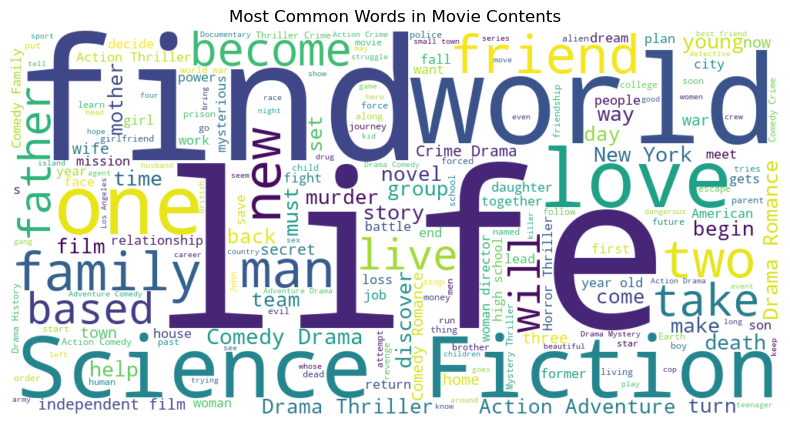

In [18]:
# wordcloud of the most common words 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Movie Contents')
plt.show()

In [20]:
stop_words = set(stopwords.words('english'))

In [21]:
def process_text(text):
    # remove special characters 
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # convert to lowercase 
    text = text.lower() 
    # toknize and remove stopwords 
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [22]:
# apply preprocessing to the movie content 
data['cleaned_text'] = df['combined_coln'].apply(process_text)


C:\Users\USER\AppData\Local\Temp\ipykernel_9944\1922348094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cleaned_text'] = df['combined_coln'].apply(process_text)


In [23]:
data.head()

,title,combined_coln,cleaned_text
0,Avatar,Action Adventure Fantasy Science Fiction cultu...,action adventure fantasy science fiction cultu...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drug abuse exot...,adventure fantasy action ocean drug abuse exot...
2,Spectre,Action Adventure Crime spy based on novel secr...,action adventure crime spy based novel secret ...
3,The Dark Knight Rises,Action Crime Drama Thriller dc comics crime fi...,action crime drama thriller dc comics crime fi...
4,John Carter,Action Adventure Science Fiction based on nove...,action adventure science fiction based novel m...


In [24]:
# vectorization 
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer = vectorizer.fit_transform(data['cleaned_text'])

In [25]:
# cosine similarity 
cosine_sim = cosine_similarity(vectorizer, vectorizer)

In [35]:
# recommendation function
def recommend_movie(title, cosine_sim=cosine_sim, dataframe=data, top_n=10):
    # locate the index of the input movies
    idx = dataframe[dataframe['title'].str.lower() == title.lower()].index
    
    # handle case where song is not found
    if len(idx) == 0: 
        return 'Movie not found in the dataset'

    # get the actual integer index
    idx = idx[0]  

    # get similarity scores between this song and all others
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort by similarity score in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # get the top_n most similar songs (excluding itself at [0])
    sim_scores = sim_scores[1:top_n + 1]

    # get the indices of the recommended songs
    movie_indices = [i[0] for i in sim_scores]

    # return the recommended song titles
    return dataframe['title'].iloc[movie_indices]


In [27]:
data['title']

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
4382                                        Bang
4383                                      Primer
4384                                 El Mariachi
4385                   Signed, Sealed, Delivered
4386                           My Date with Drew
Name: title, Length: 4387, dtype: object

In [31]:
movie_title = data['title'][99]
print(movie_title)

X-Men: First Class


In [36]:
# recommendation 
print(f'Recommendation for the move " {movie_title} "')
recommendations = recommend_movie(movie_title)
print(recommendations)

Recommendation for the move " X-Men: First Class "
506                         X-Men
201                            X2
64              X-Men: Apocalypse
33          X-Men: The Last Stand
46     X-Men: Days of Future Past
120      X-Men Origins: Wolverine
172           The Incredible Hulk
16                   The Avengers
92        Guardians of the Galaxy
14                   Man of Steel
Name: title, dtype: object
